
# 4_0-model-1-cnn.ipynb





Keras and TF tutorial example

**Input** images in .png from data directory

**Output** multiclass model

---


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import preprocessing
import PIL
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils

In [ ]:
#!pip install tf-nightly

# Hard codes and params

In [15]:
# production
dir_path_images = '/home/blue/general-assembly/dsir-824/blog/sara-capstone-cuda/data/processed/melspec/'

image_size = (180,180)
batch_size = 16

In [16]:
# test
test_path = '/home/blue/general-assembly/dsir-824/blog/sara-capstone-cuda/data/processed/melspec/baroque/img_150_baroque.png'
image = PIL.Image.open(test_path)
width, height = image.size
print(width,height)

720 288


In [17]:
df_train = tf.keras.preprocessing.image_dataset_from_directory(
    dir_path_images,
    image_size=(180,180),
    validation_split=0.2,
    subset='training',
    seed=42,
    batch_size=batch_size,
)

df_val = tf.keras.preprocessing.image_dataset_from_directory(
    dir_path_images,
    image_size=(180,180),
    validation_split=0.2,
    subset='validation',
    seed=42,
    batch_size=batch_size,
)

Found 425 files belonging to 4 classes.
Using 340 files for training.


ResourceExhaustedError: OOM when allocating tensor with shape[] and type bool on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Equal]

In [ ]:
plt.figure(figsize=(10,10))

for images, labels in df_train.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(int(labels[i]))
    plt.axis('off')
    print('Finished: ' + str(i))

# Data Augmentation

In [8]:
data_augmentation = keras.Sequential()

# Get Data

In [9]:
#df_train = df_train.prefetch(buffer_size=32)
#df_val = df_val.prefetch(buffer_size=32)

In [10]:
df_val

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

# Make Model (simple 

In [11]:
df_train

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [14]:
model = Sequential()
model.add(Conv2D(filters=16,
                 kernel_size=(3,3),
                 activation='relu',
                 input_shape=(180,180,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

ResourceExhaustedError: OOM when allocating tensor with shape[] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Sub]

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Make Model (simple)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(16, 3, padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))
    x = layers.Conv2D(64, 3, activation='relu')
    x = layers.MaxPooling2D(pool_size=(2, 2))
    x = layers.Flatten()
    x = layers.Dense(64, activation='relu')
    x = layers.Dropout(0.5)
    x = layers.Dense(32, activation='relu')
    x = layers.Dropout(0.5)
    x = layers.Dense(10, activation='softmax')
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs), x

In [ ]:
model = make_model(input_shape=image_size + (1,), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)

# Make Model (complex)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs), x

<tf.Tensor 'dropout_17/Identity:0' shape=(None, 1024) dtype=float32>

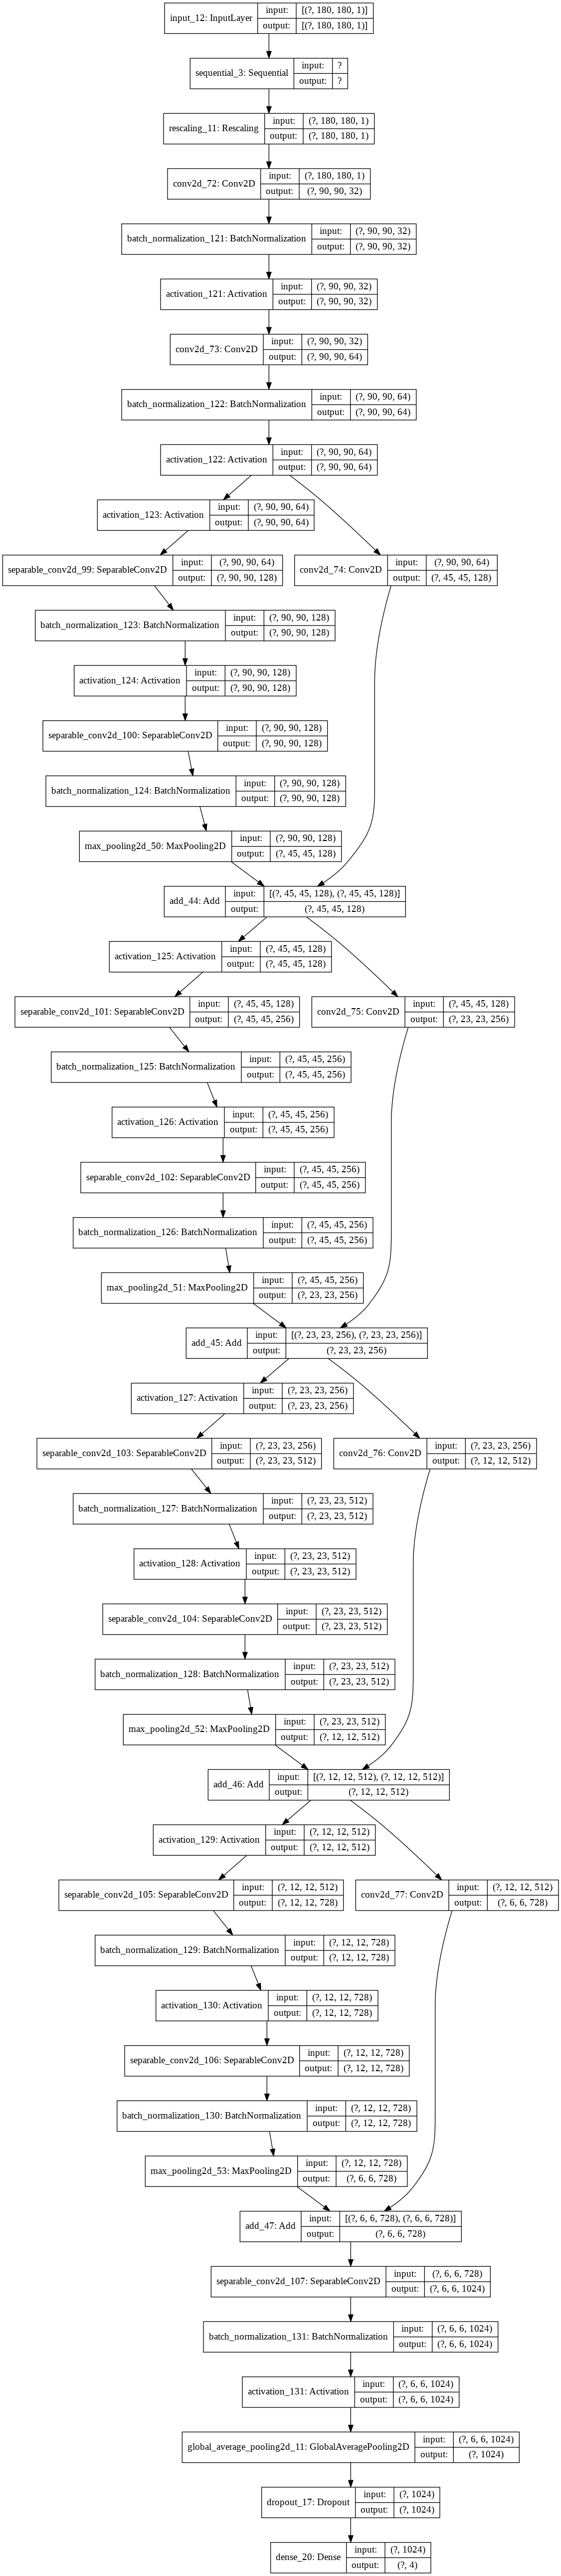

In [ ]:
model, x = make_model(input_shape=image_size + (1,), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 10

callbacks = [
             keras.callbacks.ModelCheckpoint('save_at_{epoch}.h5'),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.fit(df_train, epochs=epochs, callbacks=callbacks, validation_data=df_val)

Epoch 1/10


ValueError: ignored